# BERT - Bi-Directional Encoder Representation From Transformer

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.

BERT Paper :
https://arxiv.org/pdf/1810.04805.pdf

## BERT Embedding

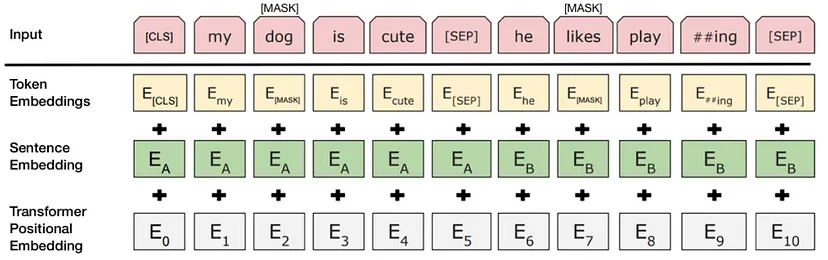


## BERT Archietecture
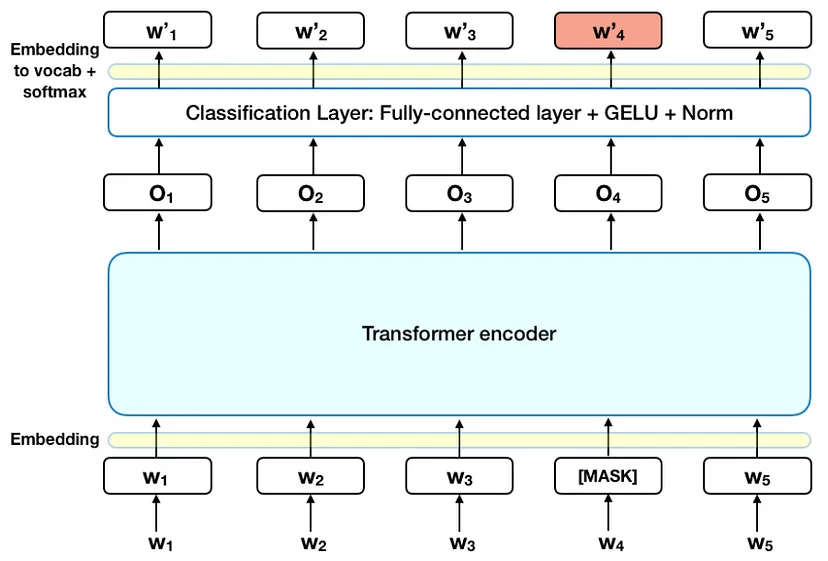

## BERT PERFORMANCE

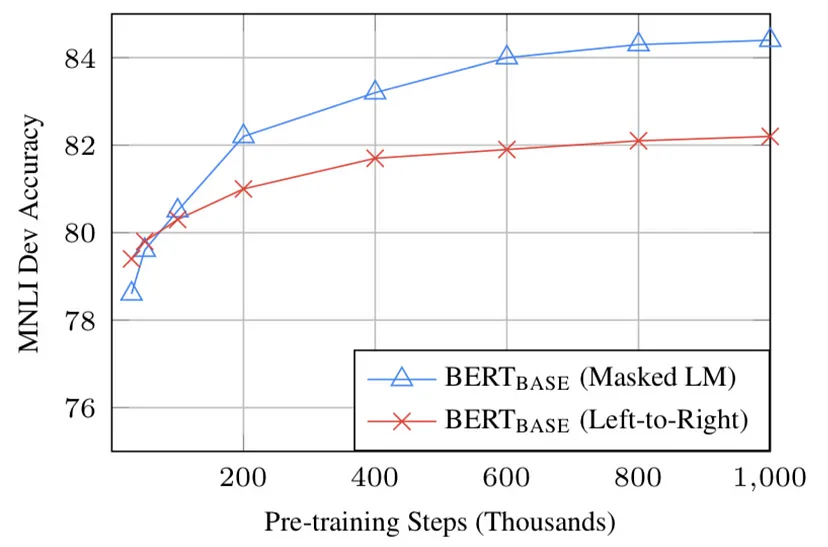

# BERT EMBEDDING IMPLEMENTATION

In [10]:
import torch
import torch.nn as nn

class BERTEmbedding(nn.Module):
    def __init__(self,
                vocab_size,
                n_segments,
                max_len,
                embed_dim,
                dropout):
        super().__init__()
        # token embedding 
        self.token_embed = nn.Embedding(vocab_size,embed_dim)     
        # segment embedding
        self.seg_embed = nn.Embedding(n_segments,embed_dim)
        # positional embedding
        self.pos_embed = nn.Embedding(max_len,embed_dim)
        #dropout layers
        self.drop = nn.Dropout(dropout)
        # position input
        self.pos_inp = torch.tensor([i for i in range(max_len)],)
        
    def forward(self,seq,seg):
        # addition of all embedding
        embed_val = self.token_embed(seq) + self.seg_embed(seg) + self.pos_embed(self.pos_inp)
        # dropout layers
        embed_val = self.drop(embed_val)
        return embed_val
    
    
class BERT(nn.Module):
    def __init__(self,vocab_size,n_segments,max_len,embed_dim,n_layers,atten_heads,dropout):
        super().__init__()
        # applied embedding
        self.embedding = BERTEmbedding(vocab_size,n_segments,max_len,embed_dim,dropout)
        # encoder layers & encoder blocks 
        self.encoder_layer = nn.TransformerEncoderLayer(embed_dim,atten_heads,embed_dim*4)
        self.encoder_block = nn.TransformerEncoder(self.encoder_layer,n_layers)
        
    def forward(self,seq,seg):
        out = self.embedding(seq,seg)
        out = self.encoder_block(out)
        return out
    
#testing 

if __name__ == "__main__":
    VOCAB_SIZE = 30000   # vocabulary_size of inputs or datasets
    N_SEGMENTS = 3       # number of sentence segmentation
    MAX_LEN = 512        # MAx_length of sentence
    EMBED_DIM = 768      # embedding vector dimensions
    N_LAYERS = 12        # number of encoders
    ATTN_HEADS = 12      # number of attention heads
    DROPOUT = 0.1        # droput rate 
    
    
    # create inputs 
    sample_seq = torch.randint(high = VOCAB_SIZE, size = [MAX_LEN,])
    sample_seg = torch.randint(high = N_SEGMENTS, size = [MAX_LEN,])
    
    # applied embedding
    embedding = BERTEmbedding(VOCAB_SIZE,N_SEGMENTS,MAX_LEN,EMBED_DIM,DROPOUT)
    embedding_tensor = embedding(sample_seq,sample_seg)
    print(embedding_tensor.size())   
    
    # applied BERT 
    bert = BERT(VOCAB_SIZE,N_SEGMENTS,MAX_LEN,EMBED_DIM,N_LAYERS,ATTN_HEADS,DROPOUT)
    out = bert(sample_seq,sample_seg)
    print(out.size())   # embedded vectors 

torch.Size([512, 768])
torch.Size([512, 768])


## BERT IMPLEMENTATION - FULL CODE

In [21]:
# import required libraries and datasets
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel,BertTokenizerFast

device = torch.device('cpu')  

class JointEmbedding(nn.Module):
    def __init__(self,vocab_size,size):
        super(JointEmbedding,self).__init__()
        self.size = size
        
        self.token_embed = nn.Embedding(vocab_size,size)
        self.seg_embed = nn.Embedding(vocab_size,size)
        
        self.norm = nn.LayerNorm(size)
        
    def forward(self,input_tensor):
        sentence_size = input_tensor.size(-1)
        pos_tensor = self.attention_position(self.size,input_tensor)
        
        segment_tensor = torch.zeros_like(input_tensor).to(device)
        segment_tensor[:,sentence_size // 2 + 1:] = 1
        
        output = self.token_embed(input_tensor) + self.seg_embed(segment_tensor) + pos_tensor
        return self.norm(output)
    
    def attention_position(self,dim,input_tensor):
        batch_size = input_tensor.size(0)
        sentence_size = input_tensor.size(-1)
        
        pos = torch.arange(sentence_size,dtype=torch.long).to(device)
        d = torch.arange(dim,dtype=torch.long)
        d = (2 * (d / dim))
        
        pos = pos.unsqueeze(1)
        pos= pos  / (1e4 ** d)
        
        pos[:, ::2] = torch.sin(pos[:, ::2])
        pos[:, 1::2] = torch.cos(pos[:, 1::2])
        
        return pos.expand(batch_size,*pos.size())
    
    def numeric_position(self,dim_inp,input_tensor):
        pos_tensor = torch.arange(dim, dtype=torch.long).to(device)
        return pos_tensor.expand_as(input_tensor)
    
    
class AttentionHead(nn.Module):

    def __init__(self, dim_inp, dim_out):
        super(AttentionHead, self).__init__()

        self.dim_inp = dim_inp

        self.q = nn.Linear(dim_inp, dim_out)
        self.k = nn.Linear(dim_inp, dim_out)
        self.v = nn.Linear(dim_inp, dim_out)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor = None):
        query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)

        scale = query.size(1) ** 0.5
        scores = torch.bmm(query, key.transpose(1, 2)) / scale

        scores = scores.masked_fill_(attention_mask, -1e9)
        attn = f.softmax(scores, dim=-1)
        context = torch.bmm(attn, value)

        return context
    
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, dim_inp, dim_out):
        super(MultiHeadAttention, self).__init__()

        self.heads = nn.ModuleList([
            AttentionHead(dim_inp, dim_out) for _ in range(num_heads)
        ])
        self.linear = nn.Linear(dim_out * num_heads, dim_inp)
        self.norm = nn.LayerNorm(dim_inp)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        s = [head(input_tensor, attention_mask) for head in self.heads]
        scores = torch.cat(s, dim=-1)
        scores = self.linear(scores)
        return self.norm(scores)
    
class Encoder(nn.Module):

    def __init__(self, dim_inp, dim_out, attention_heads=4, dropout=0.1):
        super(Encoder, self).__init__()

        self.attention = MultiHeadAttention(attention_heads, dim_inp, dim_out)  # batch_size x sentence size x dim_inp
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_inp, dim_out),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim_out, dim_inp),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim_inp)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        context = self.attention(input_tensor, attention_mask)
        res = self.feed_forward(context)
        return self.norm(res)
    
class BERT(nn.Module):

    def __init__(self, vocab_size, dim_inp, dim_out, attention_heads=4):
        super(BERT, self).__init__()

        self.embedding = JointEmbedding(vocab_size, dim_inp)
        self.encoder = Encoder(dim_inp, dim_out, attention_heads)

        self.token_prediction_layer = nn.Linear(dim_inp, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.classification_layer = nn.Linear(dim_inp, 2)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_tensor)
        encoded = self.encoder(embedded, attention_mask)

        token_predictions = self.token_prediction_layer(encoded)

        first_word = encoded[:, 0, :]
        return self.softmax(token_predictions), self.classification_layer(first_word)
        